# Lösungen

Im Folgenden wird ein Experiment, mit welchem der Zusammenhang von individueller Segregationspräferenz und realisierter Segregation untersucht werden kann, implementiert.

## Schritt 1 - Daten sammeln

Zunächst muss die Funktion `run_model()` so verändert werden, dass die gewünschten Daten eines Simulationsdurchlaufs gesammelt werden. Am Ende der Funktion `run_model()` werden daher u.a. die realisierte Segregation als durchschnittliche Anzahl von Nachbarn der eigenen Gruppe sowie die individuelle Segregationspräferenz (`threshold`) in einem Dictionary gesammelt und ausgegeben.

In [1]:
import random

def create_grid(n_rows, n_cols, n_group1, n_group2):
    # Grid als Liste von Listen erstellen und auf jede Position eine unbewohnte Zelle setzen
    grid = []
    for i in range(n_rows):
        row = []
        for j in range(n_cols):
            cell = {
                "row": i,
                "col": j,
                "resident": 0,
                "share_of_same_group": None,
                "neighbor_cells": [],
            }
            row.append(cell)
            
        grid.append(row)
    
    # Alle Zellen auch in einer normalen, flachen Liste speichern, 
    # damit man einfacher per For-Loop alle Zellen durchgehen kann
    cell_population = []
    for row in grid:
        for cell in row:
            cell_population.append(cell)
    
    # für jede Zelle die benachbarten Zellen finden
    for cell in cell_population:
        find_neighbor_cells(cell, grid)
    
    # Agenten der Gruppe 1 auf Grid setzen
    for i in range(n_group1):
        empty_cells, occupied_cells = get_empty_and_occupied_cells(cell_population)
        random_empty_cell = random.choice(empty_cells)
        random_empty_cell["resident"] = 1

    # Agenten der Gruppe 2 auf Grid setzen
    for i in range(n_group2):
        empty_cells, occupied_cells = get_empty_and_occupied_cells(cell_population)
        random_empty_cell = random.choice(empty_cells)
        random_empty_cell["resident"] = 2
    
    return grid, cell_population



def find_neighbor_cells(cell, grid):
    # Anzahl der Zeilen des Grids ermitteln
    n_rows = len(grid)
    
    # Anzahl der Spalten bzw. Zellen in einer Zeile des Grids anhand der ersten Zeile ermitteln
    n_cols = len(grid[0])
    
    # für jede Zweilenpositionsabweichung
    for row_deviation in [-1, 0, 1]:
         
        # für jede Spaltenpositionsabweichung
        for col_deviation in [-1, 0, 1]:
            
            # wenn nicht Zeilen- und Spaltenabweichung beide 0 sind
            if not (row_deviation == 0 and col_deviation == 0):
            
                # Zeilen- und Spaltenposition der Nachbarzelle berechnen
                neighbor_row = (cell["row"] - row_deviation) % n_rows
                neighbor_col = (cell["col"] - col_deviation) % n_cols

                # Nachbarzelle im grid finden und der betrachteten Zelle in die Liste von Nachbarzellen einfügen
                neighbor_cell = grid[neighbor_row][neighbor_col]
                cell["neighbor_cells"].append(neighbor_cell)
                

def get_empty_and_occupied_cells(cell_population):
    
    # Liste für alle unbewohnten Zellen
    empty_cells = []
    
    # Liste für alle bewohnten Zellen
    occupied_cells = []
    
    # Alle Zellen durchgehen und prüfen, ob Zelle unbewohnt. Dann entsprechender Liste anhängen.
    for cell in cell_population:
        if cell["resident"] == 0:
            empty_cells.append(cell)
        else:
            occupied_cells.append(cell)
    
    return empty_cells, occupied_cells


def eval_neighborhood(cell):
    # Variable zur Zählung der aktuell bewohnten Nachbarzellen
    n_neighbors = 0
    
    # Variable zur Zählung der durch Mitglieder derselben Gruppe bewohnte Nachbarzellen
    n_neighbors_of_same_group = 0
    
    # für jede Nachbarzelle
    for neighbor_cell in cell["neighbor_cells"]:
        
        # wenn Zelle bewohnt, n_neighbors um 1 erhöhen
        if neighbor_cell["resident"] != 0:
            n_neighbors += 1
        
        # wenn Zelle mit Mitglied derselben Gruppe bewohnt, dann n_neighbors_of_same_group um 1 erhöhen
        if neighbor_cell["resident"] == cell["resident"]:
            n_neighbors_of_same_group += 1
    
    # Wenn es Nachbarn gibt
    if n_neighbors > 0:
        # Anteil derselben Gruppe unter Nachbarn berechnen und einspeichern
        cell["share_of_same_group"] = n_neighbors_of_same_group / n_neighbors
    
    # ansonten
    else:
        # "Missing" eintragen
        cell["share_of_same_group"] = 999
        

def run_model(threshold, ticks=10000, n_rows=20, n_cols=20, n_group1=180, n_group2=180):
    
    # Grid erstellen
    grid, cell_population = create_grid(n_rows, n_cols, n_group1, n_group2)
    
    ###############################################
    # Simulationsloop
    ###############################################
    
    # für jeden Zeitschritt
    for tick in range(ticks):
        
        # zwei Listen mit allen leeren und bewohnten Zellen erstellen
        empty_cells, occupied_cells = get_empty_and_occupied_cells(cell_population)
        
        # eine zufällige Zelle aussuchen
        random_cell = random.choice(occupied_cells)
        
        # ausgesuchte Zelle schaut, wie hoch der Anteil der eigenen Gruppe in Nachbarschaft ist
        eval_neighborhood(random_cell)
        
        # Wenn in Nachbarschaft zu wenige aus derselben Gruppe wie Agent sind
        if random_cell["share_of_same_group"] < threshold:
            
            # zufällige neue, unbewohnte Zelle aussuchen
            new_cell = random.choice(empty_cells)
            
            # der neuen Zelle den Agenten zuweisen
            new_cell["resident"] = random_cell["resident"]
            
            # den Agenten bei alter Zelle "löschen"
            random_cell["resident"] = 0
    
    
    ###############################################
    # Daten sammeln
    ###############################################
    
    # Am Ende der Simulation für jede Zelle die Zusammensetzung der Nachbarschaft aktualisieren und sammeln
    segregation_data = []
    for cell in cell_population:
        eval_neighborhood(cell)
        
        # "ungültige Werte ausschließen"
        if cell["share_of_same_group"] <= 1: 
            segregation_data.append(cell["share_of_same_group"])
    
    # Durchschnittliche Segregation für Population berechnen
    segregation = sum(segregation_data) / len(segregation_data)
    
    # Daten in Dictionary zusammentragen und ausgeben
    output_dict = {
        "segregation": segregation,
        "threshold": threshold,
        "ticks": ticks,
        "n_rows": n_rows,
        "n_cols": n_cols,
        "n_rows": n_rows,
    }
    
    return output_dict

## Schritt 2 - Experiment durchführen

Da der Parameter `threshold` die unabhängige Variable darstellt, wird dieser im Folgenden variiert, sodass das Simulationsmodell jeweils mit unterschiedlichen Werten für `threshold` und mit jeweils mehreren Replikationen durchgeführt wird. Die von jedem Simulationsdurchgang produzierten Dictionaries werden in der Liste `data` gespeichert und schließlich in einen Dataframe namens `df` überführt.

In [2]:
import pandas as pd

# Sammelliste für Ergebnisse/Dictionaries der einzelnen Simulationsdurchgänge
data = []

# Anzahl der verschiedenen Parameterwerte
steps = 100

# Anzahl der Wiederholungen pro Parameterwert
replications = 10

# für jede Zahl von 0 bis 99
for i in range(steps):
    
    # Wert für threshold "berechnen"
    threshold = i / 100
    
    # für jede Wiederholung für diesen Parameterwert
    for rep in range(replications):
        
        # Simulation laufen lassen & Daten in Variable speichern
        results = run_model(threshold=threshold)
        
        # Daten an Sammelliste anhängen
        data.append(results)

# Daten in Dataframe überführen
df = pd.DataFrame(data)

In [3]:
df.head()

,segregation,threshold,ticks,n_rows,n_cols
0,0.481848,0.0,10000,20,20
1,0.470699,0.0,10000,20,20
2,0.461202,0.0,10000,20,20
3,0.451387,0.0,10000,20,20
4,0.455313,0.0,10000,20,20


In [4]:
df.tail()

,segregation,threshold,ticks,n_rows,n_cols
995,0.475756,0.99,10000,20,20
996,0.449301,0.99,10000,20,20
997,0.486420,0.99,10000,20,20
998,0.457122,0.99,10000,20,20
999,0.495985,0.99,10000,20,20


## Schritt 3 - Ergebnisse darstellen

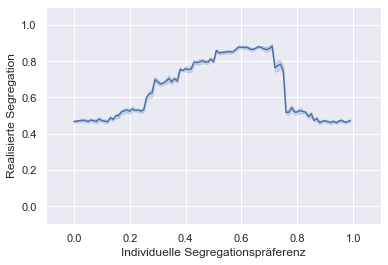

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Farbschema einstellen
sns.set_theme()

# Diagramme malen
sns.lineplot(data=df, x="threshold", y="segregation")

# sichtbare Wertebereiche der Achsen einstellen
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])

# Achsen beschriften
plt.xlabel("Individuelle Segregationspräferenz")
plt.ylabel("Realisierte Segregation")

# Diagramm anzeigen
plt.show()

- Die individuelle Segregationspräferenz übersetzt sich weder "1 zu 1" in die realisierte Segregation noch gibt es einen linearen Zusammenhang zwischen diesen beiden Variablen.

- Es scheint ein Grundlevel an realisierter Segregation von ca. 0.5 zu geben. Dies bedeutet, dass die beiden Gruppen gut durchmischt sind und eine Person durchschnittlich 50% Nachbarn der eigenen Gruppe und 50% Nachbarn der anderen Gruppe hat.

- Bereits jedoch ab einer individuellen Segregationspräferenz von 0.2 bis 0.3 beginnt die realisierte Segregation über das Basislevel von 0.5 hinaus stark anzusteigen und bei vergleichsweise niedrigen Segregationspräferenzen nun vergleichsweise starke Segregation zu erzeugen. Bis zu einer individuellen Segregationspräferenz von ca. 0.7 wird jeweils im Vergleich zu den individuellen Präferenzen eine stark "überhöhte" Segregation realisiert.

- Ab einer Segregationspräferenz von ca. 0.7 sinkt die realisierte Segregation wieder auf das "Basis-Niveau" ab. Dies ist damit zu erklären, dass nun die Bedürfnisse der Agenten nicht mehr erfüllt werden zu scheinen, diese daher ständig auf einen zufälligen neuen Platz umziehen und somit eine ständige Durchmischung erzeugen. Dieser Effekt ist jedoch vermutlich auf die spezielle Implementierung des Modells zurückzuführen: Würden Agenten beispielsweise bei Unzufriedenheit mit der Nachbarschaft nicht auf einen zufälligen neuen Ort umziehen, sondern nur auf Orte mit einer "besseren" Zusammensetzung der Nachbarschaft, dann würde vermutlich kein Absinken, sondern lediglich eine Stagnation der realisierten Segregation bei sehr hohen individuellen Segregationspräferenzen zu beobachten sein.